In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
dre_dir = os.path.abspath(os.path.join(parent_dir, "density_ratio_estimation/scripts"))
scripts_dir = os.path.abspath(os.path.join(parent_dir, "scripts"))
tscv_dir = os.path.abspath(os.path.join(parent_dir, "tscv/src/tscv/"))
sys.path.append(dre_dir)
sys.path.append(scripts_dir)
sys.path.append(tscv_dir)
import numpy as np
import pandas as pd
from common_metrics import *
from density_ratio_estimators import *
from models import *
from plotnine import *
from preprocessors import *
from scipy.spatial.distance import mahalanobis
from scipy.optimize import minimize
from sklearn.metrics import confusion_matrix
from tscv import *
from typing import Optional, Tuple

Try KNN3 model on simulated data. Draw $x$'s from standard Gaussian, then create $y$'s after multiplying $X$ by $\sqrt{V}$. Try $V = I$, $V = I$ except top diagonal entries are different.

Also, try making $\texttt{sigmoid\_scale}$ adaptive. Use sigmoid to get gradient directions, choose $\pm\epsilon\nabla$ based on true precision.

Try multiple random starts.

In [2]:
# Assuming validate_prop, x, and y are already defined
validate_prop = 0.2
x = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y = np.array([1, 2, 3, 4, 5])

# Calculate the number of training samples
# n_train = int((1 - validate_prop) * x.shape[0])
n_validate = int(validate_prop * x.shape[0])

# Split the data into training and validation sets
# x_train = x[:n_train]
x_train = x[:-n_validate]
# x_validate = x[n_train:]
x_validate = x[-n_validate:]
# y_train = y[:n_train]
y_train = y[:-n_validate]
# y_validate = y[n_train:]
y_validate = y[-n_validate:]

print("x_train:", x_train)
print("x_validate:", x_validate)
print("y_train:", y_train)
print("y_validate:", y_validate)

x_train: [[1 2]
 [3 4]
 [5 6]
 [7 8]]
x_validate: [[ 9 10]]
y_train: [1 2 3 4]
y_validate: [5]


In [3]:
def _calc_sigmoid(x: np.ndarray, sigmoid_scale: float) -> Optional[np.ndarray]:
    return 1 / (1 + np.exp(-sigmoid_scale * x))

x = np.array([-1, 0, 1])
print(_calc_sigmoid(x, sigmoid_scale=0.01))
print(_calc_sigmoid(x, sigmoid_scale=0.1))
print(_calc_sigmoid(x, sigmoid_scale=1))
print(_calc_sigmoid(x, sigmoid_scale=10))
print(_calc_sigmoid(x, sigmoid_scale=100))

print(_calc_sigmoid(x=np.array([False, True, False]), sigmoid_scale=100))

[0.49750002 0.5        0.50249998]
[0.47502081 0.5        0.52497919]
[0.26894142 0.5        0.73105858]
[4.53978687e-05 5.00000000e-01 9.99954602e-01]
[3.72007598e-44 5.00000000e-01 1.00000000e+00]
[0.5 1.  0.5]


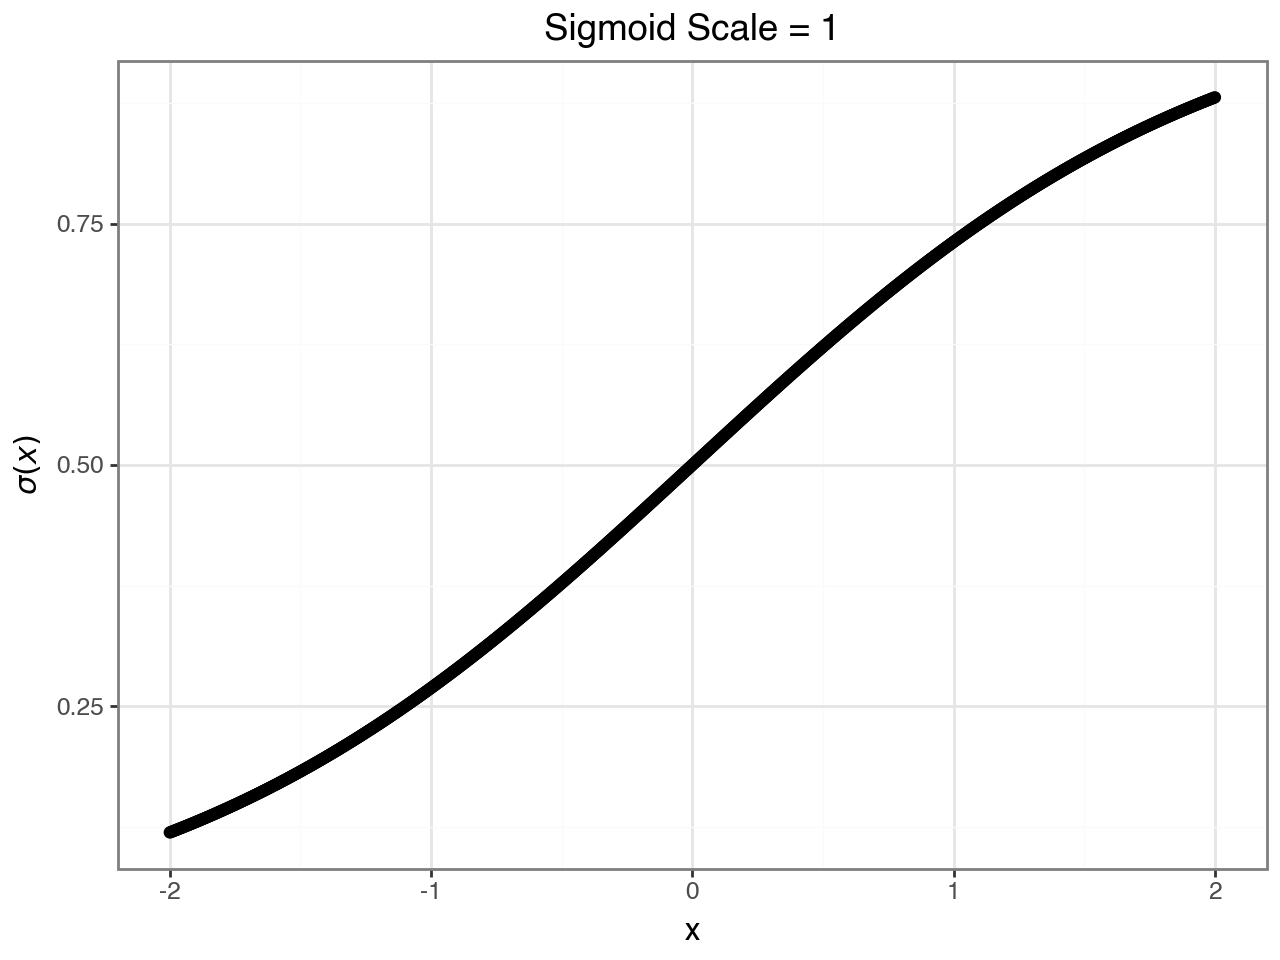

In [4]:
x = np.linspace(-2, 2, num=1001)
sigmoid_scale = 2 ** 0
y = np.array(list(map(lambda x: _calc_sigmoid(x, sigmoid_scale), x)))
df = pd.DataFrame({"x": x, "y": y})
(
    ggplot(data=df, mapping=aes(x="x", y="y")) +
    geom_point() +
    ylab(r"$\sigma(x)$") +
    ggtitle(f"Sigmoid Scale = {sigmoid_scale}") +
    theme_bw()
)

In [5]:
from scipy.optimize import minimize, rosen, rosen_der

x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = minimize(rosen, x0, method='BFGS', jac=rosen_der, options={'gtol': 1e-6, 'disp': True})

print(res.x)
res.fun

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
[1. 1. 1. 1. 1.]


1.4759786947522541e-15

In [36]:
class KNN3Model(Model):
    def __init__(
            self,
            k_numer: int,
            k_denom: int,
            p: float,
            label: str,
            validate_prop: Optional[float] = 0.2,
            min_precision_rel_chg: float = 1e-4,
            max_num_steps: int = 100,
            init_sigmoid_scale: float = 16,
            offset_scale: float = 1,
            min_grad_norm: float = 1e-4,
            max_num_sigmoid_scales: float = 10,
            sigmoid_scale_multiplier: float = 0.8,
            max_num_step_sizes: int = 10,
            step_size_multiplier: float = 1.2
        ) -> None:
        self.k_numer = k_numer
        self.k_denom = k_denom
        self.p = p
        self._label = label
        self.validate_prop = validate_prop
        self.min_precision_rel_chg = min_precision_rel_chg
        self.max_num_steps = max_num_steps
        self.init_sigmoid_scale = init_sigmoid_scale
        self.offset_scale = offset_scale
        self.min_grad_norm = min_grad_norm
        self.max_num_sigmoid_scales = max_num_sigmoid_scales
        self.sigmoid_scale_multiplier = sigmoid_scale_multiplier
        self.max_num_step_sizes = max_num_step_sizes
        self.step_size_multiplier = step_size_multiplier

    @property
    def label(self) -> str:
        return self._label

    def _calc_sigmoid(self, x: np.ndarray, sigmoid_scale: float) -> Optional[np.ndarray]:
        return 1 / (1 + np.exp(-sigmoid_scale * x))

    def _calc_grad(self, obj_fun: callable, v: np.ndarray, sigmoid_scale: float, offset_scale: float) -> np.ndarray:
        dim = len(v)
        grad = np.empty(dim, float)
        for i in range(dim):
            offset = np.zeros(dim)
            offset[i] = offset_scale
            grad[i] = (obj_fun(v + offset, sigmoid_scale) - obj_fun(v - offset, sigmoid_scale)) / (2 * offset_scale)
        return grad

    def _calc_step_direction(
            self,
            obj_fun: callable,
            v: np.ndarray,
            max_num_sigmoid_scales: int,
            init_sigmoid_scale: float,
            sigmoid_scale_multiplier: float,
            offset_scale: float,
            min_grad_norm: float
        ) -> np.ndarray:
        sigmoid_scale = init_sigmoid_scale
        grad = self._calc_grad(obj_fun, v, sigmoid_scale, offset_scale)
        grad_norm = np.linalg.norm(grad, ord=2)
        num_sigmoid_scales = 1
        while grad_norm < min_grad_norm and num_sigmoid_scales <= max_num_sigmoid_scales:
            sigmoid_scale *= sigmoid_scale_multiplier
            grad = self._calc_grad(obj_fun, v, sigmoid_scale, offset_scale)
            grad_norm = np.linalg.norm(grad, ord=2)
            num_sigmoid_scales += 1
        step_direction = grad / np.linalg.norm(grad, ord=2)
        return sigmoid_scale, step_direction

    def _calc_step_size(
            self,
            obj_fun: callable,
            v: np.ndarray,
            sigmoid_scale: float,
            step_direction: np.ndarray,
            max_num_step_sizes: int,
            step_size_multiplier: float,
            curr_precision: float
        ) -> float:
        step_size = 1 / sigmoid_scale
        next_v = v + step_size * step_direction
        next_precision = obj_fun(v)
        num_step_sizes = 1
        while next_precision <= curr_precision and num_step_sizes <= max_num_step_sizes:
            step_size *= step_size_multiplier
            next_v = v + step_size * step_direction
            next_precision = obj_fun(next_v)
            num_step_sizes += 1
        return step_size

    def _maximize(
            self,
            obj_fun: callable,
            v0: float,
            min_precision_rel_chg: float,
            max_num_steps: int,
            max_num_sigmoid_scales: float,
            init_sigmoid_scale: float,
            sigmoid_scale_multiplier: float,
            offset_scale: float,
            min_grad_norm: float,
            max_num_step_sizes: int,
            step_size_multiplier: float
        ) -> Tuple[np.ndarray, float]:
        v = v0
        prev_precision = 0
        precision = obj_fun(v)
        trace = pd.DataFrame({"step_num": 0, "v": [v], "precision": precision, "sigmoid_scale": np.nan})
        precision_rel_chg = (precision - prev_precision) / prev_precision
        num_steps = 1
        while precision_rel_chg >= min_precision_rel_chg and num_steps <= max_num_steps:
            sigmoid_scale, step_direction = self._calc_step_direction(
                obj_fun, v, max_num_sigmoid_scales, init_sigmoid_scale, sigmoid_scale_multiplier, offset_scale, min_grad_norm
            )
            step_size = self._calc_step_size(obj_fun, v, sigmoid_scale, step_direction, max_num_step_sizes, step_size_multiplier, precision)
            v = v + step_size * step_direction
            prev_precision = precision
            precision = obj_fun(v)
            trace.loc[len(trace)] = {"step_num": num_steps, "v": v, "precision": precision, "sigmoid_scale": sigmoid_scale}
            precision_rel_chg = (precision - prev_precision) / prev_precision
            num_steps += 1
        return v, precision, trace

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        n_validate = int(self.validate_prop * x.shape[0])

        x_train = x[:-n_validate]
        y_train = y[:-n_validate]
        x_validate = x[-n_validate:]
        y_validate = y[-n_validate:]

        def obj_fun(v: np.ndarray, sigmoid_scale: Optional[float] = None) -> float:
            d = np.exp(v)
            D = np.diag(d)
            sqrt_D = np.sqrt(D)
            density_ratio_estimator = KNNDensityRatioEstimator(self.k_numer, self.k_denom)
            density_ratio_estimator.fit(x_numer=x_train[y_train] @ sqrt_D, x_denom=x_train[~y_train] @ sqrt_D)
            r_train = density_ratio_estimator.predict(x_train @ sqrt_D)
            pred_threshold = np.quantile(r_train, self.p, method="inverted_cdf")

            r_validate = density_ratio_estimator.predict(x_validate @ sqrt_D)
            if sigmoid_scale is None:
                _, fp, _, tp = confusion_matrix(y_validate, r_validate >= pred_threshold).ravel()
                precision = tp / (tp + fp)
            else:
                tp = np.dot(
                    self._calc_sigmoid(2 * y_validate - 1, sigmoid_scale), self._calc_sigmoid(r_validate - pred_threshold, sigmoid_scale)
                )
                fp = np.dot(
                    self._calc_sigmoid(1 - 2 * y_validate, sigmoid_scale), self._calc_sigmoid(r_validate - pred_threshold, sigmoid_scale)
                )
                precision = tp / (tp + fp)
            return precision
        
        v0 = np.ones(x.shape[1])
        v, precision, trace = self._maximize(
            obj_fun,
            v0,
            self.min_precision_rel_chg,
            self.max_num_steps,
            self.max_num_sigmoid_scales,
            self.init_sigmoid_scale,
            self.sigmoid_scale_multiplier,
            self.offset_scale,
            self.min_grad_norm,
            self.max_num_step_sizes,
            self.step_size_multiplier
        )

        self.trace = trace
        self.d = np.exp(v)
        D = np.diag(self.d)
        sqrt_D = np.sqrt(D)
        self.precision = precision

        self.density_ratio_estimator = KNNDensityRatioEstimator(self.k_numer, self.k_denom)
        self.density_ratio_estimator.fit(x_numer=x_train[y_train] @ sqrt_D, x_denom=x_train[~y_train] @ sqrt_D)
        r = self.density_ratio_estimator.predict(x @ sqrt_D)
        self.pred_threshold = np.quantile(r, self.p, method="inverted_cdf")

    def predict(self, x: np.ndarray) -> np.ndarray:
        r = self.density_ratio_estimator.predict(x)
        return r >= self.pred_threshold

In [7]:
combined_data = pd.read_parquet("../combined_data.parquet")
sharp_params = [
    "ABSNJZH", "MEANALP", "MEANGAM", "MEANGBH", "MEANGBT", "MEANGBZ", "MEANJZD", "MEANJZH",
    "MEANPOT", "MEANSHR", "SAVNCPP", "SHRGT45", "TOTPOT", "TOTUSJH", "TOTUSJZ", "USFLUX"
]

In [8]:
combined_data2 = combined_data[sharp_params + ["flux"]].copy()
combined_data2["y"] = combined_data2["flux"]
h = 3
combined_data2["y"] = combined_data2["y"].shift(-h)
combined_data2 = combined_data2.drop(combined_data2.index[-h:])
x = combined_data2[sharp_params + ["flux"]].to_numpy()
y = combined_data2["y"].to_numpy()

In [10]:
train_starts = [0]
train_size = 2000
test_starts = [2000]
test_size = 2000
p = 0.9
metrics_ = [TPR(), FPR(), Precision(), TSS()]
cross_validator = TimeSeriesCrossValidator(x, y, train_starts, train_size, test_starts, test_size, metrics_)

In [10]:
preprocessor = StandardizePreprocessor(p = p)

k_numer, k_denom, k = 100, 100, 100
p = 0.9
models = [KNN3Model(
    k_numer=k_numer,
    k_denom=k_denom,
    p=0.9,
    label="KNN3",
    validate_prop=0.2,
    minimize_method="BFGS",
    minimize_tol=1e-10,
    minimize_options={"maxiter": 10, "disp": True}
)]

In [11]:
cross_validator.cross_validate(preprocessor, models, parallelize="none")

Current iterate: [1.00041786 0.99972571 0.99989605 1.00040137 1.00016331 1.00004901
 0.99852358 0.99954696 0.99979431 0.99967349 1.00041715 0.99982822
 1.00002386 0.99998879 0.99995038 1.00022371 1.00137921], current value: -0.3933963887597573
Current iterate: [1.00485569 0.99699546 0.99814223 1.004593   1.00193073 1.00072063
 0.98296    0.99496445 0.99724753 0.99540884 1.00504197 0.99747057
 1.0002585  0.99986405 0.99937876 1.00289981 1.01765052], current value: -0.3934061167694718
Current iterate: [1.01486295 0.99065282 0.99425161 1.01418728 1.00590836 1.00216945
 0.94871521 0.98440429 0.99145106 0.98584505 1.0157206  0.99218869
 1.0008031  0.99953708 0.99806131 1.00896401 1.05590269], current value: -0.3934226966024087
Current iterate: [4.30426603e+00 3.90466311e-01 5.55134699e-01 4.29859188e+00
 1.81625931e+00 1.25018135e+00 4.96633382e-03 2.04910857e-01
 4.05709722e-01 2.30251160e-01 4.52851202e+00 4.43592621e-01
 1.07582209e+00 9.55376089e-01 8.17832852e-01 2.52222875e+00
 2.7154

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.


,train_start,train_end,test_start,test_end,model,TPR,FPR,Precision,TSS
0,0,1999,2000,3999,KNN3,0.009662,0.028444,0.037736,-0.018782


In [47]:
preprocessor = StandardizePreprocessor(p = p)

k_numer, k_denom, k = 100, 100, 100
p = 0.9
models = [KNN3Model(
    k_numer=k_numer,
    k_denom=k_denom,
    p=0.9,
    label="KNN3",
    validate_prop=0.2,
    min_precision_rel_chg = -1e-1,
    max_num_steps = 50,
    init_sigmoid_scale = 2,
    offset_scale = 1e-8,
    min_grad_norm = 1e-4,
    max_num_sigmoid_scales = 10,
    sigmoid_scale_multiplier = 0.8,
    max_num_step_sizes = 100,
    step_size_multiplier = 1 + 1e-5
)]

In [48]:
cross_validator.cross_validate(preprocessor, models, parallelize="none")

/var/folders/0j/7bxrsnld6539ckmfpj6bgs4w0000gs/T/ipykernel_6152/1103231347.py:111: RuntimeWarning: divide by zero encountered in scalar divide


,train_start,train_end,test_start,test_end,model,TPR,FPR,Precision,TSS
0,0,1999,2000,3999,KNN3,0.028986,0.040714,0.075949,-0.011728


In [49]:
models[0].trace

,step_num,v,precision,sigmoid_scale
0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.250000,NaN
1,1,"[1.0475390729388847, 0.9495312250026844, 0.980...",0.271186,2.0
2,2,"[0.969187985262103, 0.9650538814826142, 0.9673...",0.253968,2.0
3,3,"[0.9615161864368481, 0.9392829516674739, 0.959...",0.274194,2.0
4,4,"[1.0205740669505852, 0.8692211014284108, 0.871...",0.257143,2.0
5,5,"[1.0577417388336272, 0.79345670277936, 0.84032...",0.312500,2.0
6,6,"[0.9890759954764011, 0.7568301293214847, 0.755...",0.333333,2.0
7,7,"[0.9002858305321685, 0.8448970772741735, 0.804...",0.301587,2.0
8,8,"[0.9835501051225002, 0.9394696540674459, 0.799...",0.281250,2.0
9,9,"[0.906715813233745, 0.8969571365390757, 0.7451...",0.256410,2.0


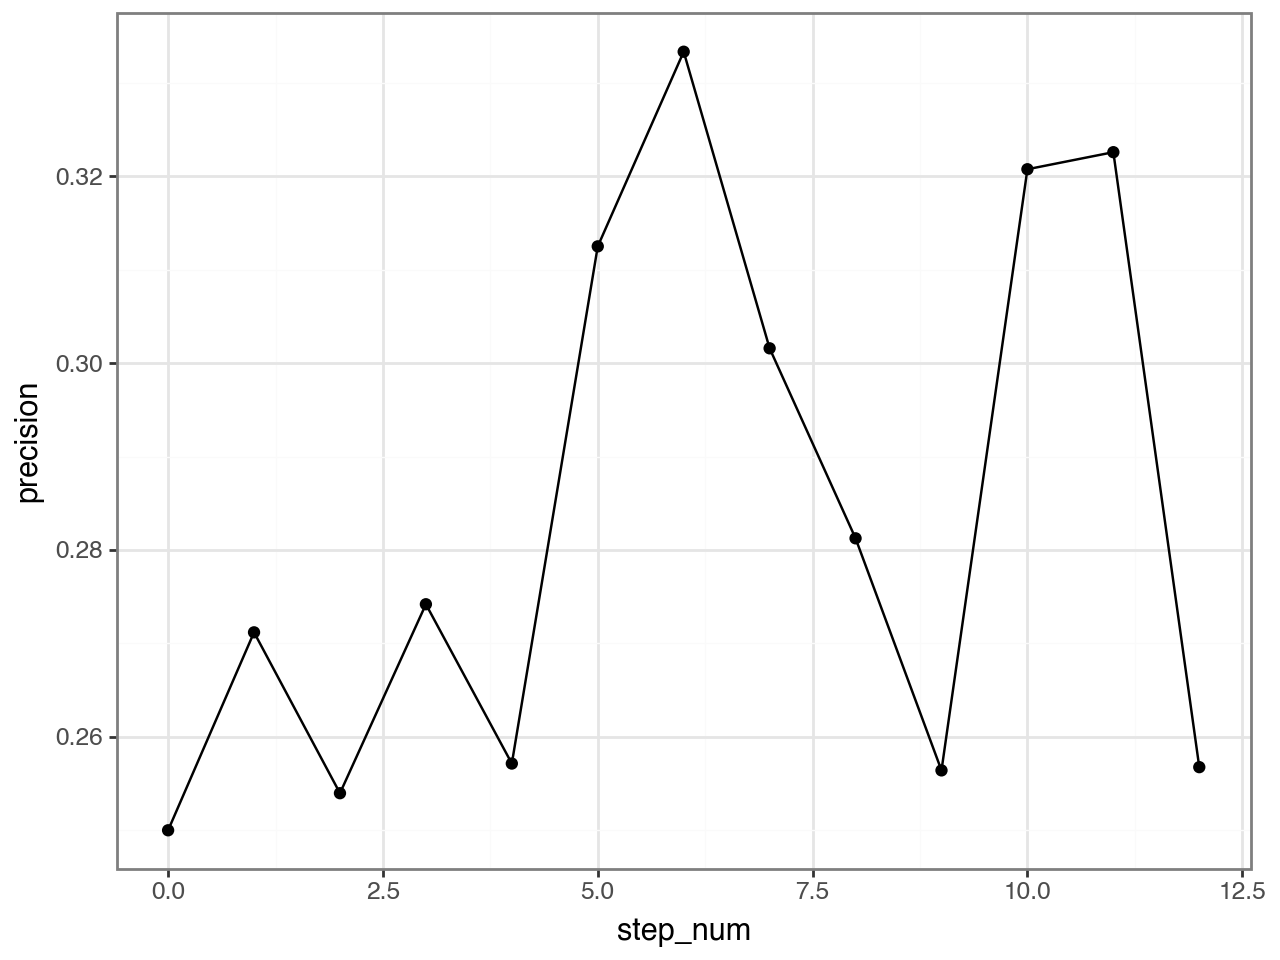

In [50]:
(
    ggplot(data=models[0].trace, mapping=aes(x="step_num", y="precision")) +
    geom_point() +
    geom_line() +
    theme_bw()
)

In [51]:
models[0].d

array([ 2.62838989,  2.81146678,  1.65970415,  2.53199476,  2.55869914,
        2.59782979,  2.07365428,  2.76816833,  2.29131412,  1.65973285,
        1.97996627,  1.70208892,  2.7129075 ,  2.20802974,  2.47481516,
        2.49524251, 43.00017862])

In [16]:
combined_data.columns

Index(['T_REC', 'ABSNJZH', 'MEANALP', 'MEANGAM', 'MEANGBH', 'MEANGBT',
       'MEANGBZ', 'MEANJZD', 'MEANJZH', 'MEANPOT', 'MEANSHR', 'SAVNCPP',
       'SHRGT45', 'TOTPOT', 'TOTUSJH', 'TOTUSJZ', 'USFLUX', 'flux',
       'were_sharp_params_imputed', 'was_flux_imputed'],
      dtype='object')